# Construcción de modelos de aprendizaje

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
!ls

sample_data  spark-3.1.1-bin-hadoop3.2	spark-3.1.1-bin-hadoop3.2.tgz


In [4]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
# !wget https://jacobceles.github.io/knowledge_repo/colab_and_pyspark/cars.csv
path_file = '/content/drive/MyDrive/BigData_Maestria/Clase/cars.csv'

In [7]:
df = spark.read.csv(path_file, header=True, sep=";", inferSchema=True)
df.show(5)

+--------------------+----+---------+------------+----------+------+------------+-----+------+
|                 Car| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
|Chevrolet Chevell...|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|
|   Buick Skylark 320|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|
|  Plymouth Satellite|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|
|       AMC Rebel SST|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|
|         Ford Torino|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|
+--------------------+----+---------+------------+----------+------+------------+-----+------+
only showing top 5 rows



In [9]:
print("Número de registros: " + str(df.count()))
print("Número de columnas: " + str(len(df.columns)))

Número de registros: 406
Número de columnas: 9


In [10]:
df.describe()

summary,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
count,406,406,406,406,406,406,406,406,406
mean,null,23.051231527093602,5.475369458128079,194.7795566502463,103.5295566502463,2979.4138,15.519704433497521,75.92118226600985,null
stddev,null,8.4017773522706,1.712159631548529,104.92245837948867,40.52065912106347,847.0043282393513,2.8033588163425462,3.7487373454558743,null
min,AMC Ambassador Br...,0.0,3,68.0,0.0,1613,8.0,70,Europe
max,Volvo Diesel,46.6,8,455.0,230.0,5140,24.8,82,US


In [11]:
df.printSchema()

root
 |-- Car: string (nullable = true)
 |-- MPG: double (nullable = true)
 |-- Cylinders: integer (nullable = true)
 |-- Displacement: double (nullable = true)
 |-- Horsepower: double (nullable = true)
 |-- Weight: decimal(4,0) (nullable = true)
 |-- Acceleration: double (nullable = true)
 |-- Model: integer (nullable = true)
 |-- Origin: string (nullable = true)



#### Etapa 1: Feature Engineering y Transformers

Se va a implementar un proceso de clasificación para predecir la variable "Origen". Primero se implementan algunos pasos de pre-procesamiento para eliminar información no relevante, así como algunas transformaciones sobre los datos.

In [12]:
#Se elimina la columna "car", ya que no es de interés para el experimento
df = df.drop('Car')
df.show(5)

+----+---------+------------+----------+------+------------+-----+------+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+----+---------+------------+----------+------+------------+-----+------+
|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|
|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|
|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|
|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|
|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|
+----+---------+------------+----------+------+------------+-----+------+
only showing top 5 rows



### Limpieza de datos


In [13]:
#Se eliminan registros con valores nulos
df_clean = df.dropna()

#Se eliminan columnas con valores nulos
df_clean = df_clean.na.drop()

#Se eliminan registros duplicados
df_clean = df_clean.dropDuplicates()

#### Preparación del df - vectorización de features

In [14]:
# Ejemplo1: con el uso de RFormula
from pyspark.ml.feature import RFormula
rForm = RFormula(formula="Origin ~ .")
fittedRF = rForm.fit(df_clean)
preparedDF_a = fittedRF.transform(df_clean)
preparedDF_a.show(5)

+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
|27.9|        4|       156.0|     105.0|  2800|        14.4|   80|    US|[27.9,4.0,156.0,1...|  0.0|
|37.0|        4|        85.0|      65.0|  1975|        19.4|   81| Japan|[37.0,4.0,85.0,65...|  1.0|
|13.0|        8|       350.0|     175.0|  4100|        13.0|   73|    US|[13.0,8.0,350.0,1...|  0.0|
| 0.0|        4|       121.0|     110.0|  2800|        15.4|   81|Europe|[0.0,4.0,121.0,11...|  2.0|
| 0.0|        8|       383.0|     175.0|  4166|        10.5|   70|    US|[0.0,8.0,383.0,17...|  0.0|
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
only showing top 5 rows



In [15]:
# Ejemplo2: preparación con VectorAssembler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

# Se genera el vector de features
assembler = VectorAssembler(inputCols=['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration'], outputCol = 'features')
preparedDF_b = assembler.transform(df_clean)

# Se añade una nueva columna transformando la variable objetivo a una columna númerica
indexer = StringIndexer(inputCol="Origin", outputCol="label")
preparedDF_b = indexer.fit(preparedDF_b).transform(preparedDF_b)

preparedDF_b.show(5)

+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
|27.9|        4|       156.0|     105.0|  2800|        14.4|   80|    US|[27.9,4.0,156.0,1...|  0.0|
|37.0|        4|        85.0|      65.0|  1975|        19.4|   81| Japan|[37.0,4.0,85.0,65...|  1.0|
|13.0|        8|       350.0|     175.0|  4100|        13.0|   73|    US|[13.0,8.0,350.0,1...|  0.0|
| 0.0|        4|       121.0|     110.0|  2800|        15.4|   81|Europe|[0.0,4.0,121.0,11...|  2.0|
| 0.0|        8|       383.0|     175.0|  4166|        10.5|   70|    US|[0.0,8.0,383.0,17...|  0.0|
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
only showing top 5 rows



In [16]:
# Se comparan ambos planes de transformación
preparedDF_a.explain()
preparedDF_b.explain()

== Physical Plan ==
*(2) Project [MPG#17, Cylinders#18, Displacement#19, Horsepower#20, Weight#21, Acceleration#22, Model#23, Origin#24, features#1593, UDF(Origin#24) AS label#1625]
+- *(2) HashAggregate(keys=[Cylinders#18, Horsepower#20, Origin#24, Weight#21, Model#23, MPG#17, Acceleration#22, Displacement#19], functions=[])
   +- Exchange hashpartitioning(Cylinders#18, Horsepower#20, Origin#24, Weight#21, Model#23, MPG#17, Acceleration#22, Displacement#19, 200), ENSURE_REQUIREMENTS, [id=#253]
      +- *(1) HashAggregate(keys=[Cylinders#18, knownfloatingpointnormalized(normalizenanandzero(Horsepower#20)) AS Horsepower#20, Origin#24, Weight#21, Model#23, knownfloatingpointnormalized(normalizenanandzero(MPG#17)) AS MPG#17, knownfloatingpointnormalized(normalizenanandzero(Acceleration#22)) AS Acceleration#22, knownfloatingpointnormalized(normalizenanandzero(Displacement#19)) AS Displacement#19], functions=[])
         +- *(1) Filter AtLeastNNulls(n, MPG#17,Cylinders#18,Displacement#19,Ho

#### Etapa 2: aprendizaje
#### Preparación de los conjuntos train y test

Se exponen dos casos diferentes: primero, aplicando un muestreo aleatorio simple con una división 80 - 20. Segundo, con un muestreo estratificado a partir de dos variables: origen y cilindros.

Es importante recordar que PySpark, por default, define 200 ejecutores para las transformaciones. Si no se controla este hecho, se pueden obtener resultados no deseados si es que las particiones tienen un número limitado en instancias.

In [17]:
print("Número de registros: " + str(preparedDF_a.count()))

Número de registros: 406


##### Caso 1: muestreo aleatorio simple

In [18]:
# Ejemplo 1
# Construcción de un train - test con 200 ejecutores por default
spark.conf.set("spark.sql.shuffle.partitions", "200")
train_data_rand_200w_a,test_data_rand_200w_a = preparedDF_a.randomSplit([0.7,0.3], seed = 42)
print(f"""Existen {train_data_rand_200w_a.count()} instancias en el conjunto train, y {test_data_rand_200w_a.count()} en el conjunto test""")

Existen 273 instancias en el conjunto train, y 133 en el conjunto test


In [19]:
# Construcción de un train - test con 1 ejecutor
spark.conf.set("spark.sql.shuffle.partitions", "1")
train_data_rand_1w_a,test_data_rand_1w_a = preparedDF_a.randomSplit([0.7,0.3], seed = 42)
print(f"""Existen {train_data_rand_1w_a.count()} instancias en el conjunto train, y {test_data_rand_1w_a.count()} en el conjunto test""")

Existen 304 instancias en el conjunto train, y 102 en el conjunto test


##### Caso 2: muestreo estratificado

Muestreo a partir de las variables Origin y Cylinders

In [20]:
# Se añade una nueva columna que combina los valores de los atributos Cylinders y Origin
from pyspark.sql.functions import concat, lit
preparedDF_a_stratum = preparedDF_a.withColumn("stratum", concat(preparedDF_a["Origin"], lit("_"), preparedDF_a["Cylinders"]))
preparedDF_a_stratum.show(5)


+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|stratum|
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|[18.0,8.0,307.0,1...|  0.0|   US_8|
|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|[15.0,8.0,350.0,1...|  0.0|   US_8|
|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|[18.0,8.0,318.0,1...|  0.0|   US_8|
|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|[16.0,8.0,304.0,1...|  0.0|   US_8|
|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|[17.0,8.0,302.0,1...|  0.0|   US_8|
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
only showing top 5 

In [21]:
preparedDF_a_stratum.printSchema()

root
 |-- MPG: double (nullable = true)
 |-- Cylinders: integer (nullable = true)
 |-- Displacement: double (nullable = true)
 |-- Horsepower: double (nullable = true)
 |-- Weight: decimal(4,0) (nullable = true)
 |-- Acceleration: double (nullable = true)
 |-- Model: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- stratum: string (nullable = true)



In [22]:
# Se calcula la cantidad de instancias por cada valor diferente de las variables Origin, Cylinder y combinada
stratum_counts_origin = preparedDF_a_stratum.groupBy("Origin").count().collect()
stratum_counts_cylinders = preparedDF_a_stratum.groupBy("Cylinders").count().collect()
stratum_counts_combined_a = preparedDF_a_stratum.groupBy("Origin", "Cylinders").count().collect()
stratum_counts_combined = preparedDF_a_stratum.groupBy("stratum").count().collect()

print(stratum_counts_origin)
print(stratum_counts_cylinders)
print(stratum_counts_combined_a)
print(stratum_counts_combined)


[Row(Origin='US', count=254), Row(Origin='Europe', count=73), Row(Origin='Japan', count=79)]
[Row(Cylinders=8, count=108), Row(Cylinders=4, count=207), Row(Cylinders=6, count=84), Row(Cylinders=3, count=4), Row(Cylinders=5, count=3)]
[Row(Origin='US', Cylinders=8, count=108), Row(Origin='Europe', Cylinders=4, count=66), Row(Origin='Japan', Cylinders=4, count=69), Row(Origin='US', Cylinders=6, count=74), Row(Origin='US', Cylinders=4, count=72), Row(Origin='Japan', Cylinders=3, count=4), Row(Origin='Japan', Cylinders=6, count=6), Row(Origin='Europe', Cylinders=6, count=4), Row(Origin='Europe', Cylinders=5, count=3)]
[Row(stratum='US_8', count=108), Row(stratum='Europe_4', count=66), Row(stratum='Japan_4', count=69), Row(stratum='US_6', count=74), Row(stratum='US_4', count=72), Row(stratum='Japan_3', count=4), Row(stratum='Japan_6', count=6), Row(stratum='Europe_6', count=4), Row(stratum='Europe_5', count=3)]


Observe que existe desbalance entre los estratos. Esto en un experimento formal se debería de corregir.

In [23]:
# Se calcula la probabilidad del test de cada bin de acuerdo al porcentaje de division a usar (70 - 30)
total_count = preparedDF_a_stratum.count()
# Se calcula la fracción del test
stratum_fractions = {row["stratum"]: 0.3 * (row["count"] / total_count)
                     for row in stratum_counts_combined}
print(stratum_fractions)

{'US_8': 0.07980295566502463, 'Europe_4': 0.04876847290640394, 'Japan_4': 0.05098522167487684, 'US_6': 0.054679802955665026, 'US_4': 0.053201970443349754, 'Japan_3': 0.0029556650246305416, 'Japan_6': 0.004433497536945812, 'Europe_6': 0.0029556650246305416, 'Europe_5': 0.002216748768472906}


In [24]:
# Se generan los conjuntos a partir de muestreo estratificado
test_data_stratum = preparedDF_a_stratum.sampleBy("stratum", fractions=stratum_fractions, seed=42)
train_data_stratum = preparedDF_a_stratum.exceptAll(test_data_stratum)

print(f"""Existen {train_data_stratum.count()} instancias en el conjunto train, y {test_data_stratum.count()} en el conjunto test""")

train_data_stratum.show(5)
test_data_stratum.show(5)

Existen 378 instancias en el conjunto train, y 28 en el conjunto test
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|stratum|
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|[18.0,8.0,307.0,1...|  0.0|   US_8|
|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|[15.0,8.0,350.0,1...|  0.0|   US_8|
|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|[18.0,8.0,318.0,1...|  0.0|   US_8|
|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|[16.0,8.0,304.0,1...|  0.0|   US_8|
|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|[17.0,8.0,302.0,1...|  0.0|   US_8|
+----+---------+------------+----------+------+-----------

In [25]:
# EJEMPLO ALTERNATIVO DE MUESTREO ESTRATIFICADO A PARTIR DE LA UNION DE PARTICIONES

#se inicializa train_data_stratum y test_data_stratum como dataframes vacios
train_data_stratum_parts = []
test_data_stratum_parts = []

# Ejemplo alternativo: a partir de la extracción de cada partición
for row in stratum_counts_combined:
  stratum = row['stratum']
  # se extraen todos los registros con el valor de stratum
  stratum_df = preparedDF_a_stratum.filter(preparedDF_a_stratum.stratum == stratum)
  # Se genera la particion 70 - 30 deseada
  train_data_stratified, test_data_stratified = stratum_df.randomSplit([0.7, 0.3], seed=42)
  # Se unen los conjuntos
  train_data_stratum_parts.append(train_data_stratified)
  test_data_stratum_parts.append(test_data_stratified)



In [26]:
#from pyspark.sql.functions import col
if train_data_stratum_parts:
    # Use the first DataFrame as the base and union the rest
    train_data_stratum_b = train_data_stratum_parts[0]
    for i in range(1, len(train_data_stratum_parts)):
        train_data_stratum_b = train_data_stratum_b.unionAll(train_data_stratum_parts[i])
if test_data_stratum_parts:
    # Use the first DataFrame as the base and union the rest
    test_data_stratum_b = test_data_stratum_parts[0]
    for i in range(1, len(test_data_stratum_parts)):
        test_data_stratum_b = test_data_stratum_b.unionAll(test_data_stratum_parts[i])

print(f"""Existen {train_data_stratum_b.count()} instancias en el conjunto train, y {test_data_stratum_b.count()} en el conjunto test""")

train_data_stratum_b.show(5)
test_data_stratum_b.show(5)

Existen 246 instancias en el conjunto train, y 160 en el conjunto test
+---+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|stratum|
+---+---------+------------+----------+------+------------+-----+------+--------------------+-----+-------+
|0.0|        8|       302.0|     140.0|  3353|         8.0|   70|    US|[0.0,8.0,302.0,14...|  0.0|   US_8|
|0.0|        8|       350.0|     165.0|  4142|        11.5|   70|    US|[0.0,8.0,350.0,16...|  0.0|   US_8|
|0.0|        8|       360.0|     175.0|  3850|        11.0|   70|    US|[0.0,8.0,360.0,17...|  0.0|   US_8|
|0.0|        8|       383.0|     175.0|  4166|        10.5|   70|    US|[0.0,8.0,383.0,17...|  0.0|   US_8|
|9.0|        8|       304.0|     193.0|  4732|        18.5|   70|    US|[9.0,8.0,304.0,19...|  0.0|   US_8|
+---+---------+------------+----------+------+------------+-----+

#### Construccion de modelos de ML con PySpark

In [27]:
# Ejemplo 1: Modelo de regresión logística, sin ajuste de parametros
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)
# se imprimen los valores de parametros por default
print (lr.explainParams())


aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [28]:
#se van a generar diferentes modelos para cada uno de los conjuntos train y test, para comparar
lrModel_a = lr.fit(train_data_rand_200w_a)
lrModel_b = lr.fit(train_data_rand_1w_a)
lrModel_c = lr.fit(train_data_stratum)
lrModel_d = lr.fit(train_data_stratum_b)

In [29]:
# Imprimiendo los valores de predicción del modelo sobre el train
lrModel_a.transform(train_data_rand_200w_a).select('Origin', 'label', 'rawPrediction', 'prediction', 'probability').show(5)
lrModel_b.transform(train_data_rand_1w_a).select('Origin', 'label', 'rawPrediction', 'prediction', 'probability').show(5)
lrModel_c.transform(train_data_stratum).select('Origin', 'label', 'rawPrediction', 'prediction', 'probability').show(5)
lrModel_d.transform(train_data_stratum_b).select('Origin', 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+------+-----+--------------------+----------+--------------------+
|Origin|label|       rawPrediction|prediction|         probability|
+------+-----+--------------------+----------+--------------------+
|Europe|  2.0|[0.26043786847694...|       2.0|[0.15313135833683...|
|Europe|  2.0|[-1.3065012024037...|       2.0|[0.02875894068629...|
|    US|  0.0|[6.66618990783002...|       0.0|[0.99987496014192...|
|    US|  0.0|[6.84355806496865...|       0.0|[0.99984706390829...|
|    US|  0.0|[7.57451664501725...|       0.0|[0.99994340242755...|
+------+-----+--------------------+----------+--------------------+
only showing top 5 rows

+------+-----+--------------------+----------+--------------------+
|Origin|label|       rawPrediction|prediction|         probability|
+------+-----+--------------------+----------+--------------------+
|Europe|  2.0|[0.26043786847694...|       2.0|[0.15313135833683...|
|Europe|  2.0|[-1.3065012024037...|       2.0|[0.02875894068629...|
|    US|  0.0|[6.666189

#### Etapa 3: evaluación

In [38]:
# Imprimiendo el accuracy de cada modelo con su respectivo test
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# se configura el evaluador para trabajar con accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_a = evaluator.evaluate(lrModel_a.transform(test_data_rand_200w_a))
accuracy_b = evaluator.evaluate(lrModel_b.transform(test_data_rand_1w_a))
accuracy_c = evaluator.evaluate(lrModel_c.transform(test_data_stratum))
accuracy_d = evaluator.evaluate(lrModel_d.transform(test_data_stratum_b))

# Imprimiendo cada resultado de accuracy
print("Accuracy for train_data_rand_200w_a: %.3f" % accuracy_a)
print("Accuracy for train_data_rand_1w_a: %.3f" % accuracy_b)
print("Accuracy for train_data_stratum: %.3f" % accuracy_c)
print("Accuracy for train_data_stratum_b: %.3f" % accuracy_d)

Accuracy for train_data_rand_200w_a: 0.725
Accuracy for train_data_rand_1w_a: 0.725
Accuracy for train_data_stratum: 0.786
Accuracy for train_data_stratum_b: 0.731


#### Creando un pipeline

Con los pipeline, se automatiza el proceso de experimentación

In [36]:
# Se generan particiones sin los ensambles y la columna de clase, para el ejemplo del pipeline

train_data_rand_200w_nofeatures = train_data_rand_200w_a.drop("features") \
                                              .drop("label")
test_data_rand_200w_nofeatures = test_data_rand_200w_a.drop("features") \
                                              .drop("label")

train_data_rand_1w_nofeatures = train_data_rand_1w_a.drop("features") \
                                              .drop("label")
test_data_rand_1w_nofeatures = test_data_rand_1w_a.drop("features") \
                                              .drop("label")

train_data_stratum_nofeatures = train_data_stratum.drop("features") \
                                              .drop("label")
test_data_stratum_nofeatures = test_data_stratum.drop("features") \
                                              .drop("label")

train_data_stratum_b_nofeatures = train_data_stratum_b.drop("features") \
                                              .drop("label")
test_data_stratum_b_nofeatures = test_data_stratum_b.drop("features") \
                                              .drop("label")



In [39]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the RFormula transformer
rForm = RFormula(formula="Origin ~ .", featuresCol="features", labelCol="label")

# Define the Logistic Regression model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)

# Create the Pipeline
pipeline = Pipeline(stages=[rForm, lr])

# se configura el evaluador para trabajar con accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Train step
# Case 1: Random split with 200 partitions
pipelineModel_a = pipeline.fit(train_data_rand_200w_nofeatures)
predictions_a = pipelineModel_a.transform(test_data_rand_200w_nofeatures)
accuracy_a_pipeline = evaluator.evaluate(predictions_a)
print("Accuracy for train_data_rand_200w_a with Pipeline: %.3f" % accuracy_a_pipeline)

# Case 1: Random split with 1 partition
pipelineModel_b = pipeline.fit(train_data_rand_1w_nofeatures)
predictions_b = pipelineModel_b.transform(test_data_rand_1w_nofeatures)
accuracy_b_pipeline = evaluator.evaluate(predictions_b)
print("Accuracy for train_data_rand_1w_a with Pipeline: %.3f" % accuracy_b_pipeline)


# Case 2: Stratified split (sampleBy)
pipelineModel_c = pipeline.fit(train_data_stratum_nofeatures)
predictions_c = pipelineModel_c.transform(test_data_stratum_nofeatures)
accuracy_c_pipeline = evaluator.evaluate(predictions_c)
print("Accuracy for train_data_stratum with Pipeline: %.3f" % accuracy_c_pipeline)


# Case 2: Stratified split (union of partitions)
pipelineModel_d = pipeline.fit(train_data_stratum_b_nofeatures)
predictions_d = pipelineModel_d.transform(test_data_stratum_b_nofeatures)
accuracy_d_pipeline = evaluator.evaluate(predictions_d)
print("Accuracy for train_data_stratum_b with Pipeline: %.3f" % accuracy_d_pipeline)

Accuracy for train_data_rand_200w_a with Pipeline: 0.725
Accuracy for train_data_rand_1w_a with Pipeline: 0.725
Accuracy for train_data_stratum with Pipeline: 1.000
Accuracy for train_data_stratum_b with Pipeline: 1.000


#### Aplicando búsqueda por rejilla en el ajuste de hiperparámetros

In [40]:
from pyspark.ml.tuning import ParamGridBuilder
# Se define la rejilla para la búsqueda de parametros con Regresión Logística
params = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 2.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [41]:
# Se especifica el proceso de evaluación a emplear para los modelos
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()\
            .setMetricName("accuracy")\
            .setPredictionCol("prediction")\
            .setLabelCol("label")


In [42]:
# Se aplica mustreo aleatorio simple con conjunto Validation, para evitar sobreajuste
from pyspark.ml.tuning import TrainValidationSplit
tvs = TrainValidationSplit()\
      .setTrainRatio(0.75)\
      .setEstimatorParamMaps(params)\
      .setEstimator(pipeline)\
      .setEvaluator(evaluator)



In [43]:
# Se prepara preparan los conjuntos train y test
train,test = df_clean.randomSplit([0.7,0.3], seed = 42)

In [44]:
# Se entrena con el pipeline generado
tvsFitted = tvs.fit(train)
evaluator.evaluate(tvsFitted.transform(test))


0.7058823529411765

#### Conociendo más sobre métricas en PySpark: clasificación binaria

In [45]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [46]:
# Se tenera un DF con dos clases a partir de la columna Origin
df_binClass = df_clean.filter((df_clean['Origin']=='Japan')|(df_clean['Origin']=='US'))
df_binClass.show(5)

+----+---------+------------+----------+------+------------+-----+------+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|
+----+---------+------------+----------+------+------------+-----+------+
|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|
|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|
|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|
|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|
|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|
+----+---------+------------+----------+------+------------+-----+------+
only showing top 5 rows



In [47]:
# Se crea una RFormula para generar el ensamble y la clase binaria
from pyspark.ml.feature import RFormula
rForm = RFormula(formula="Origin ~ .")
fittedRF = rForm.fit(df_binClass)
df = fittedRF.transform(df_binClass)
df.show(5)

+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model|Origin|            features|label|
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
|18.0|        8|       307.0|     130.0|  3504|        12.0|   70|    US|[18.0,8.0,307.0,1...|  0.0|
|15.0|        8|       350.0|     165.0|  3693|        11.5|   70|    US|[15.0,8.0,350.0,1...|  0.0|
|18.0|        8|       318.0|     150.0|  3436|        11.0|   70|    US|[18.0,8.0,318.0,1...|  0.0|
|16.0|        8|       304.0|     150.0|  3433|        12.0|   70|    US|[16.0,8.0,304.0,1...|  0.0|
|17.0|        8|       302.0|     140.0|  3449|        10.5|   70|    US|[17.0,8.0,302.0,1...|  0.0|
+----+---------+------------+----------+------+------------+-----+------+--------------------+-----+
only showing top 5 rows



In [48]:
# Se divide el dataset para propositos de entrenamiento

# Dividir datos en entrenamiento y prueba
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Definir y entrenar el modelo
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_df)

# Hacer predicciones
predictions = lr_model.transform(test_df)

# Evaluar el modelo con AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"AUC-ROC del modelo: {auc:.4f}")


AUC-ROC del modelo: 0.9585


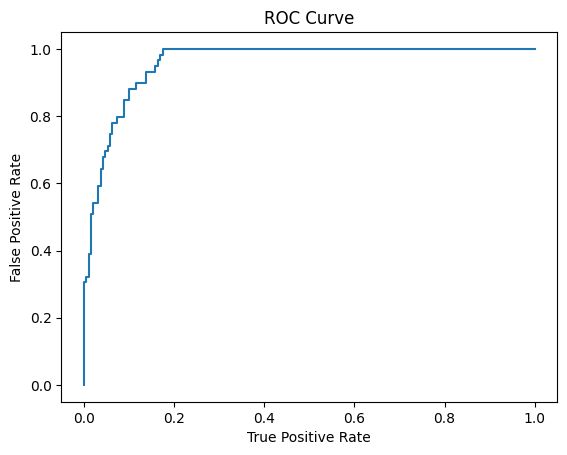

Training set areaUnderROC: 0.9586584162855348


In [49]:
# Imprimiendo la curva ROC
import matplotlib.pyplot as plt

trainingSummary = lr_model.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

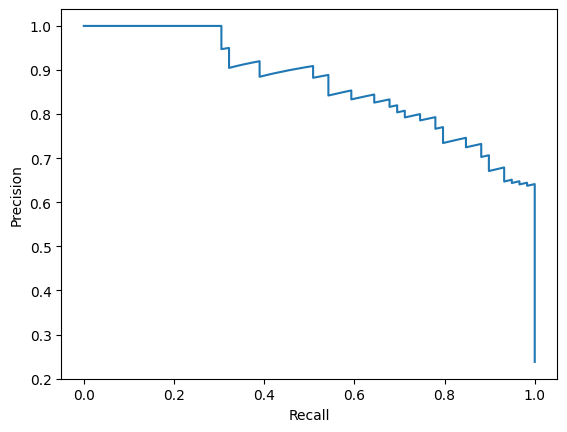

In [50]:
# Imprimiendo la curva entre Precision y Recall

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [51]:
# Se calculan los verdaderos y falsos, tanto positivos como negativos
tp = predictions.filter((predictions['label'] == 1) & (predictions['prediction'] == 1)).count()
fp = predictions.filter((predictions['label'] == 0) & (predictions['prediction'] == 1)).count()
tn = predictions.filter((predictions['label'] == 0) & (predictions['prediction'] == 0)).count()
fn = predictions.filter((predictions['label'] == 1) & (predictions['prediction'] == 0)).count()

# Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")

# Precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
print(f"Precision: {precision}")

# Recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
print(f"Recall: {recall}")

# F1 measure
f1_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
print(f"F1 measure: {f1_measure}")

Accuracy: 0.8941176470588236
Precision: 0.7894736842105263
Recall: 0.75
F1 measure: 0.7692307692307692
